In [3]:
# importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import cv2
import zipfile
import glob
import os

In [4]:
# resizing images, if needed
IMG_SIZE_X = 160
IMG_SIZE_Y = 120
num_images = 530 # total number of images
num_of_classes = 22 # given by the unique labels in mask image dataset

In [5]:
# mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# path to dataset
zip_path = "/content/drive/MyDrive/Colab Notebooks/CameraRGB160x120.zip"

# unzip the dataset
with zipfile.ZipFile(zip_path,"r") as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/Camera_dataset")

images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/*.png")
print(images)


print(f"Number of image files under CameraRGB160X120 is: {len(images)}")

['/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/010856.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011047.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011051.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011055.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011059.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011063.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011463.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011467.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011471.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011475.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB160x120/011479.png', '/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraRGB

In [ ]:
images.sort()
images = [cv2.imread(image, 0) for image in images]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset,axis=3)

In [ ]:
# extracting and reading mask images
mask_path = "/content/drive/MyDrive/Colab Notebooks/CameraMask160x120.zip"
with zipfile.ZipFile(mask_path,"r") as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/Camera_dataset")


mask_images = glob.glob("/content/drive/MyDrive/Colab Notebooks/Camera_dataset/CameraMask160x120/*png")

print(mask_images)
print(f"Number of mask image files under CameraMask160X120 is: {len(mask_images)}")

In [9]:
# cv2.imread method's second parameter should be given as 1 to read
# images in COLORED format, if 0 is given images are read as grayscale
mask_images.sort()
mask_images = [cv2.cvtColor(cv2.imread(mask_image, 1),cv2.COLOR_BGR2RGB) for mask_image in mask_images]
mask_image_dataset = np.array(mask_images)
mask_image_dataset = mask_image_dataset[:,:,:,0]
print(mask_image_dataset.shape)

(265, 120, 160)


In [10]:
print("Image data shape is: ",image_dataset.shape)
print("Mask Image data shape is: ",mask_image_dataset.shape)
print("Max pixel value in image is: ",image_dataset.max())
print("Labels in the mask are: ",np.unique(mask_image_dataset)) # gives the number of classes

Image data shape is:  (265, 120, 160, 1)
Mask Image data shape is:  (265, 120, 160)
Max pixel value in image is:  255
Labels in the mask are:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [11]:
# Encoding labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
num_of_images,height,width = mask_image_dataset.shape
mask_image_dataset_reshaped = mask_image_dataset.reshape(-1,1)
mask_image_dataset_reshaped_encoded = labelencoder.fit_transform(mask_image_dataset_reshaped)
mask_image_dataset_encoded = mask_image_dataset_reshaped_encoded.reshape(num_of_images,height,width)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# after label encoding
print("After label encoding labels in the mask are: ",np.unique(mask_image_dataset_encoded))

After label encoding labels in the mask are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [13]:
# match the size of the mask dataset with image dataset
mask_image_dataset_encoded = np.expand_dims(mask_image_dataset_encoded,axis=3)
print(mask_image_dataset_encoded.shape)

(265, 120, 160, 1)


In [14]:
# normalizing images
image_dataset = image_dataset / 255.

In [15]:
# splitting dataset into training and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(image_dataset,mask_image_dataset_encoded,test_size=0.2,random_state=42)
print(y_train.shape)
print(y_test.shape)

(212, 120, 160, 1)
(53, 120, 160, 1)


In [16]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=num_of_classes)
y_train_categorical = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], num_of_classes))

test_masks_cat = to_categorical(y_test, num_classes=num_of_classes)
y_test_categorical = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], num_of_classes))


In [17]:
print(y_train_categorical.shape)

(212, 120, 160, 22)


In [18]:
print(y_test_categorical.shape)

(53, 120, 160, 22)


In [19]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    #x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    #x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation
from keras.layers import Resizing

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)

    # Resize x to match the dimensions of skip_features before concatenation
    x = Resizing(skip_features.shape[1], skip_features.shape[2])(x)

    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    s5, p5 = encoder_block(p4, 1024)

    b1 = conv_block(p5, 2048) #Bridge

    d1 = decoder_block(b1, s5, 1024)
    d2 = decoder_block(d1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d5)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(X_train.shape)

(212, 120, 160, 1)


In [21]:
model = build_unet(input_shape,num_of_classes)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 160, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 120, 160, 64)         640       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 120, 160, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 120, 160, 64)         36928     ['activation[0][0]']          
                                                                                      

In [22]:
# training the U-Net model
history = model.fit(X_train, y_train_categorical,
                    batch_size=32,
                    epochs=200,
                    validation_data=(X_test, y_test_categorical),
                    shuffle=False)

Epoch 1/200
7/7 [==============================] - 81s 6s/step - loss: 2.8805 - accuracy: 0.3347 - val_loss: 2.7071 - val_accuracy: 0.4428
Epoch 2/200
7/7 [==============================] - 6s 843ms/step - loss: 4.3116 - accuracy: 0.3953 - val_loss: 2.5682 - val_accuracy: 0.3336
Epoch 3/200
7/7 [==============================] - 6s 847ms/step - loss: 2.3924 - accuracy: 0.3239 - val_loss: 2.0311 - val_accuracy: 0.3336
Epoch 4/200
7/7 [==============================] - 6s 862ms/step - loss: 2.0239 - accuracy: 0.3228 - val_loss: 1.7671 - val_accuracy: 0.3336
Epoch 5/200
7/7 [==============================] - 6s 869ms/step - loss: 1.7678 - accuracy: 0.3577 - val_loss: 1.6250 - val_accuracy: 0.4458
Epoch 6/200
7/7 [==============================] - 6s 877ms/step - loss: 1.7292 - accuracy: 0.3981 - val_loss: 1.5978 - val_accuracy: 0.4466
Epoch 7/200
7/7 [==============================] - 6s 882ms/step - loss: 1.6464 - accuracy: 0.4127 - val_loss: 1.5435 - val_accuracy: 0.4468
Epoch 8/200
7/7

In [25]:
# save the model for future use
model.save("/content/drive/MyDrive/Colab Notebooks/saved_models/Homework3.hdf5")

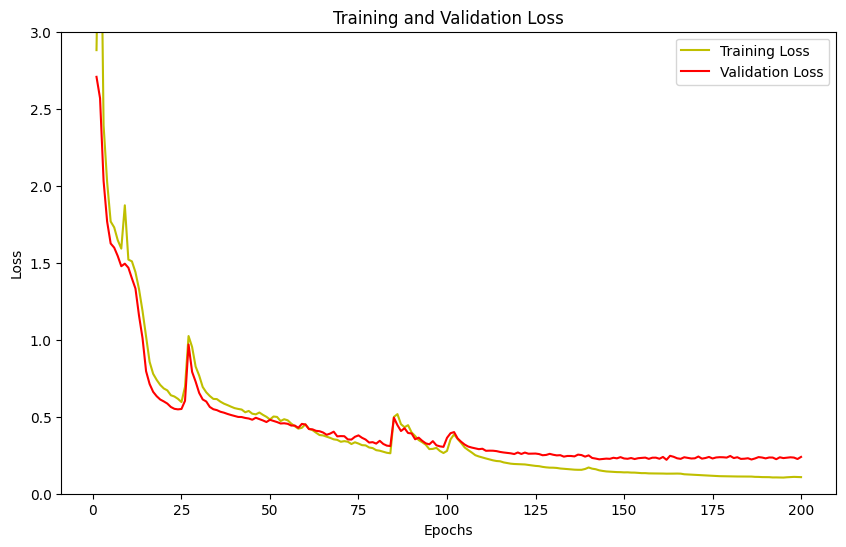

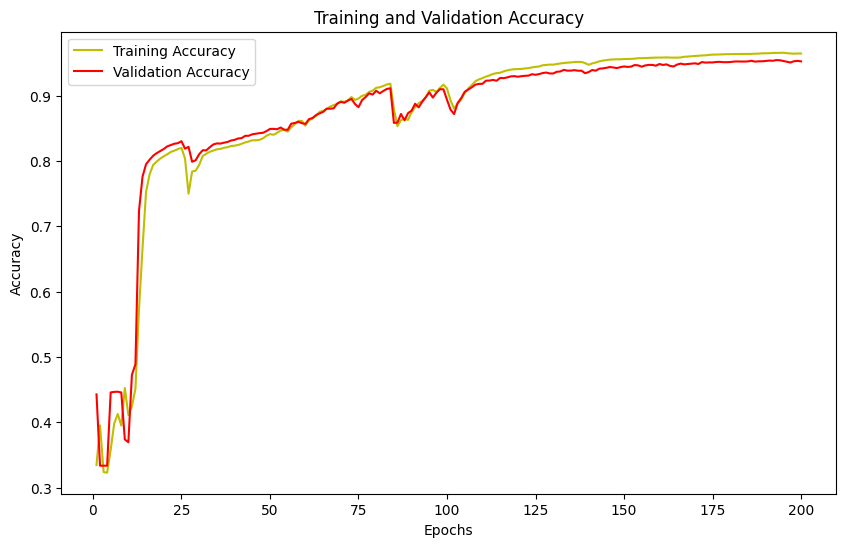

In [26]:
import matplotlib.pyplot as plt

# plot for Training and Validation Loss
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 3)
plt.legend()
plt.show()

# plot for Training and Validation Accuracy
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, "y", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [27]:
# loading previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/Homework3.hdf5")

In [29]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 246ms/step


In [30]:
# shape of predicted data
y_pred.shape

(53, 120, 160, 22)

In [31]:
# selecting highest score class for every pixel and writing it to matrix (y_pred_argmax)
y_pred_argmax = np.argmax(y_pred,axis=3)
y_pred_argmax.shape

(53, 120, 160)

In [32]:
print(y_pred_argmax [0,0:5,0:5])

[[12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]]


In [33]:
# using Mean intersection over union metric to evaluate the model
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=num_of_classes)
IOU_keras.update_state(y_test[:,:,:,0],y_pred_argmax)
print("Mean IoU =",IOU_keras.result().numpy())

Mean IoU = 0.4887561


In [34]:
# displaying mean instersection over union (MIoU) values
num_of_classes = 22
values = np.array(IOU_keras.get_weights()).reshape(num_of_classes, num_of_classes)

ious = []
for i in range(num_of_classes):
    tp = values[i, i]
    fp = np.sum(values[:, i]) - tp
    fn = np.sum(values[i, :]) - tp
    iou = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0  # avoid division by zero
    ious.append(iou)
    print(f"IoU for class {i+1} is: {iou}")

IoU for class 1 is: 0.8777123093605042
IoU for class 2 is: 0.4116809070110321
IoU for class 3 is: 0.0
IoU for class 4 is: 0.0
IoU for class 5 is: 0.13494637608528137
IoU for class 6 is: 0.6237738728523254
IoU for class 7 is: 0.9696788787841797
IoU for class 8 is: 0.628767728805542
IoU for class 9 is: 0.7593609094619751
IoU for class 10 is: 0.44179388880729675
IoU for class 11 is: 0.7881619930267334
IoU for class 12 is: 0.0
IoU for class 13 is: 0.969889760017395
IoU for class 14 is: 0.3635280132293701
IoU for class 15 is: 0.691845178604126
IoU for class 16 is: 0.6472102999687195
IoU for class 17 is: 0.8172042965888977
IoU for class 18 is: 0.0
IoU for class 19 is: 0.33872976899147034
IoU for class 20 is: 0.1624203771352768
IoU for class 21 is: 0
IoU for class 22 is: 0.6371724605560303


1/1 [==============================] - 0s 19ms/step


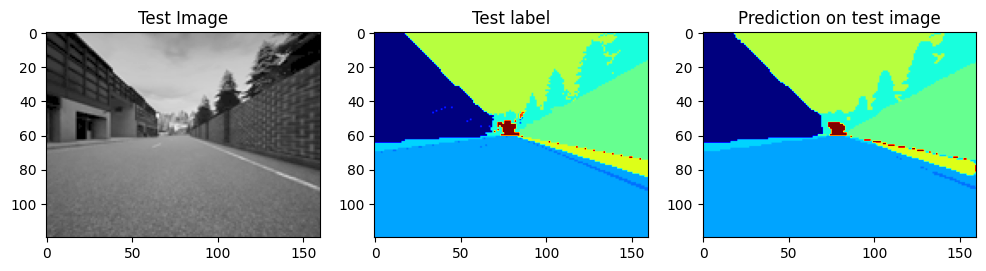

In [43]:
# testing on a sample image
import random
test_image_number = random.randint(0,len(X_test)-1)
test_image = X_test[test_image_number]
ground_truth = y_test[test_image_number]
test_image_norm = test_image[:,:,0][:,:,None]
test_image_input = np.expand_dims(test_image_norm,0)

prediction = (model.predict(test_image_input))
predicted_image = np.argmax(prediction,axis=3)[0,:,:]

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title("Test Image")
plt.imshow(test_image[:,:,0],cmap="gray")
plt.subplot(232)
plt.title("Testing label")
plt.imshow(ground_truth[:,:,0],cmap="jet")
plt.title("Test label")
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(predicted_image,cmap="jet")
plt.show()